Trying to implement a neural network planar data classification. The neural network will have 2 hidden layers with same activation functions.


I'm using load_planar_dataset to load the data, in future it will from hugging face

[Pending] Implement back propagation and error correction

###IMPORT LIBRARIES

In [236]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.linear_model

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0)


Generate Data for now

In [237]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

### Get data

In [238]:
X, y = load_planar_dataset()

###Split data into training and validation

Visualize the data

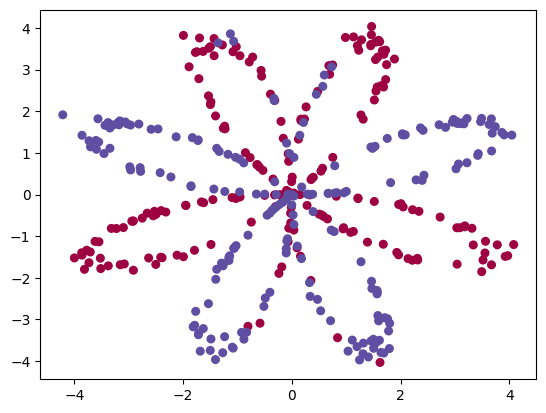

In [239]:
plt.scatter(X[0, :], X[1, :], c=y, s=30, cmap=plt.cm.Spectral)

Implementing simple logistic regression first

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 47 % (percentage of correctly labelled datapoints)


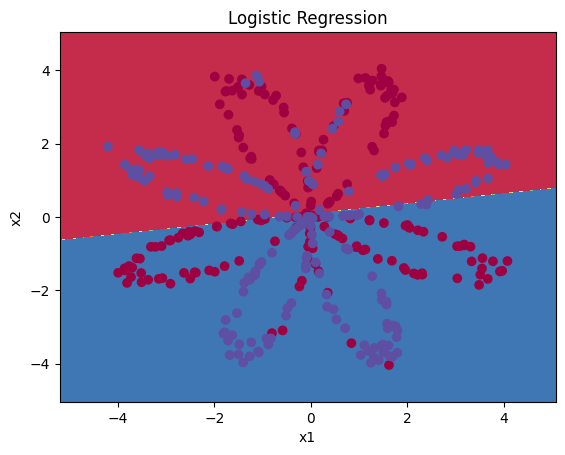

In [240]:
my_model = sklearn.linear_model.LogisticRegressionCV()
my_model.fit(X.T, y.T)

plot_decision_boundary(lambda x: my_model.predict(x), X, y)
plt.title("Logistic Regression")

preds = my_model.predict(X.T)
print ('Accuracy: %d ' % float((np.dot(y,preds) + np.dot(1-y,1-preds))/float(y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

We got shit results, lets use neural network instead

In [241]:
def layer_sizes(X, y):
  n_x = X.shape[0]
  n_h1 = 4
  n_h2 = 4
  n_y = y.shape[0]
  return (n_x, n_h1, n_h2, n_y)

def initialize_parameters(n_x, n_h1, n_h2, n_y):
  np.random.seed(1)
  W1 = np.random.randn(n_h1, n_x) * 0.01
  b1 = np.zeros((n_h1, 1))
  W2 = np.random.randn(n_h2, n_h1) * 0.01
  b2 = np.zeros((n_h2, 1))
  W3 = np.random.randn(n_y, n_h2) * 0.01
  b3 = np.zeros((n_y, 1))
  return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3 }

def forward_propagation(X, parameters):
  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']
  W3 = parameters['W3']
  b3 = parameters['b3']

  Z1 = np.dot(W1, X) + b1
  A1 = np.tanh(Z1)

  Z2 = np.dot(W2, A1) + b2
  A2 = np.tanh(Z2)

  Z3 = np.dot(W3, A2) + b3
  A3 = sigmoid(Z3)

  cache = { 'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2, 'Z3': Z3, 'A3': A3 }

  return A3, cache


def calculate_cost(A3, y, parameters):
  m = y.shape[1]
  J = -(1/m * np.sum(( (y * np.log(A3)) + ((1-y) * np.log(1-A3)) )))
  return np.squeeze(J)

def back_propagation(parameters, cache, X, y):
  m = X.shape[1]

  W1 = parameters['W1']
  W2 = parameters['W2']
  W3 = parameters['W3']

  A1 = cache['A1']
  A2 = cache['A2']
  A3 = cache['A3']

  dZ3 = A3 - y
  dW3 = (1/m) * np.dot(dZ3, A2.T)
  db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

  dZ2 = np.dot(W3.T, dZ3) * (1 - np.power(A2, 2))
  dW2 = (1/m) * np.dot(dZ2, A1.T)
  db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

  dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
  dW1 = (1/m) * np.dot(dZ1, X.T)
  db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

  gradients = { 'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3 }

  return gradients

def update_parameters(parameters, gradients, learning_rate=1.35):
  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']
  W3 = parameters['W3']
  b3 = parameters['b3']

  dW1 = gradients['dW1']
  db1 = gradients['db1']
  dW2 = gradients['dW2']
  db2 = gradients['db2']
  dW3 = gradients['dW3']
  db3 = gradients['db3']

  W1 = W1 - learning_rate * dW1
  b1 = b1 - learning_rate * db1
  W2 = W2 - learning_rate * dW2
  b2 = b2 - learning_rate * db2
  W3 = W3 - learning_rate * dW3
  b3 = b3 - learning_rate * db3

  parameters = { "W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3 }

  return parameters


def predict(parameters, X):
  # Run the model again to predict on learned values
  A3, cache = forward_propagation(X, parameters)
  predictions = A3 > 0.5
  return predictions

##Now lets make the neural network

In [242]:
def nn_model(X, y, n_h1, n_h2, iterations=1000, print_cost=False):
  np.random.seed(2)
  n_x = layer_sizes(X, y)[0]
  n_y = layer_sizes(X, y)[3]

  parameters = initialize_parameters(n_x, n_h1, n_h2, n_y)

  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']
  W3 = parameters['W3']
  b3 = parameters['b3']

  for i in range(iterations):
    # Get the value of the last Activation function
    # And get cache i.e dZ and A to do back propagation
    A3, cache = forward_propagation(X, parameters)
    J = calculate_cost(A3, y, parameters)
    gradients = back_propagation(parameters, cache, X, y)
    parameters = update_parameters(parameters, gradients)

    if print_cost and i % 10000 == 0:
      print ("Cost after iteration %i: %f" %(i, J))

  return parameters



Trigger the model

Cost after iteration 0: 0.693148
Cost after iteration 10000: 0.194932
Accuracy: 92%


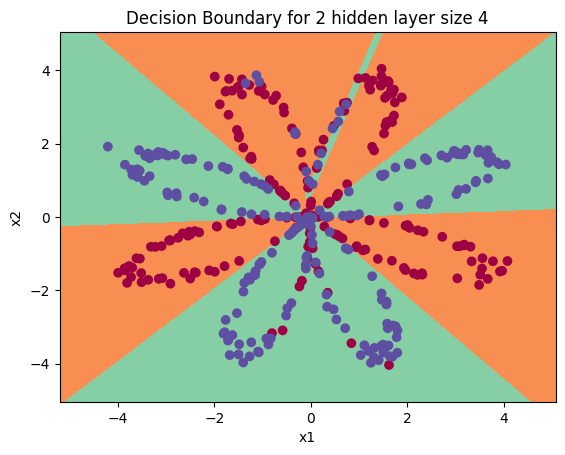

In [243]:
new_parameters = nn_model(X, y, n_h1=4, n_h2=4, iterations = 20000, print_cost = True)
plot_decision_boundary(lambda x: predict(new_parameters, x.T), X, y)
plt.title("Decision Boundary for 2 hidden layer size " + str(4))

predictions = predict(new_parameters, X)
print ('Accuracy: %d' % float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100) + '%')

##Testing hidden layer sizes

Accuracy for 1 hidden units: 68.25 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 91.5 %
Accuracy for 5 hidden units: 91.0 %
Accuracy for 20 hidden units: 92.75 %
Accuracy for 50 hidden units: 91.5 %


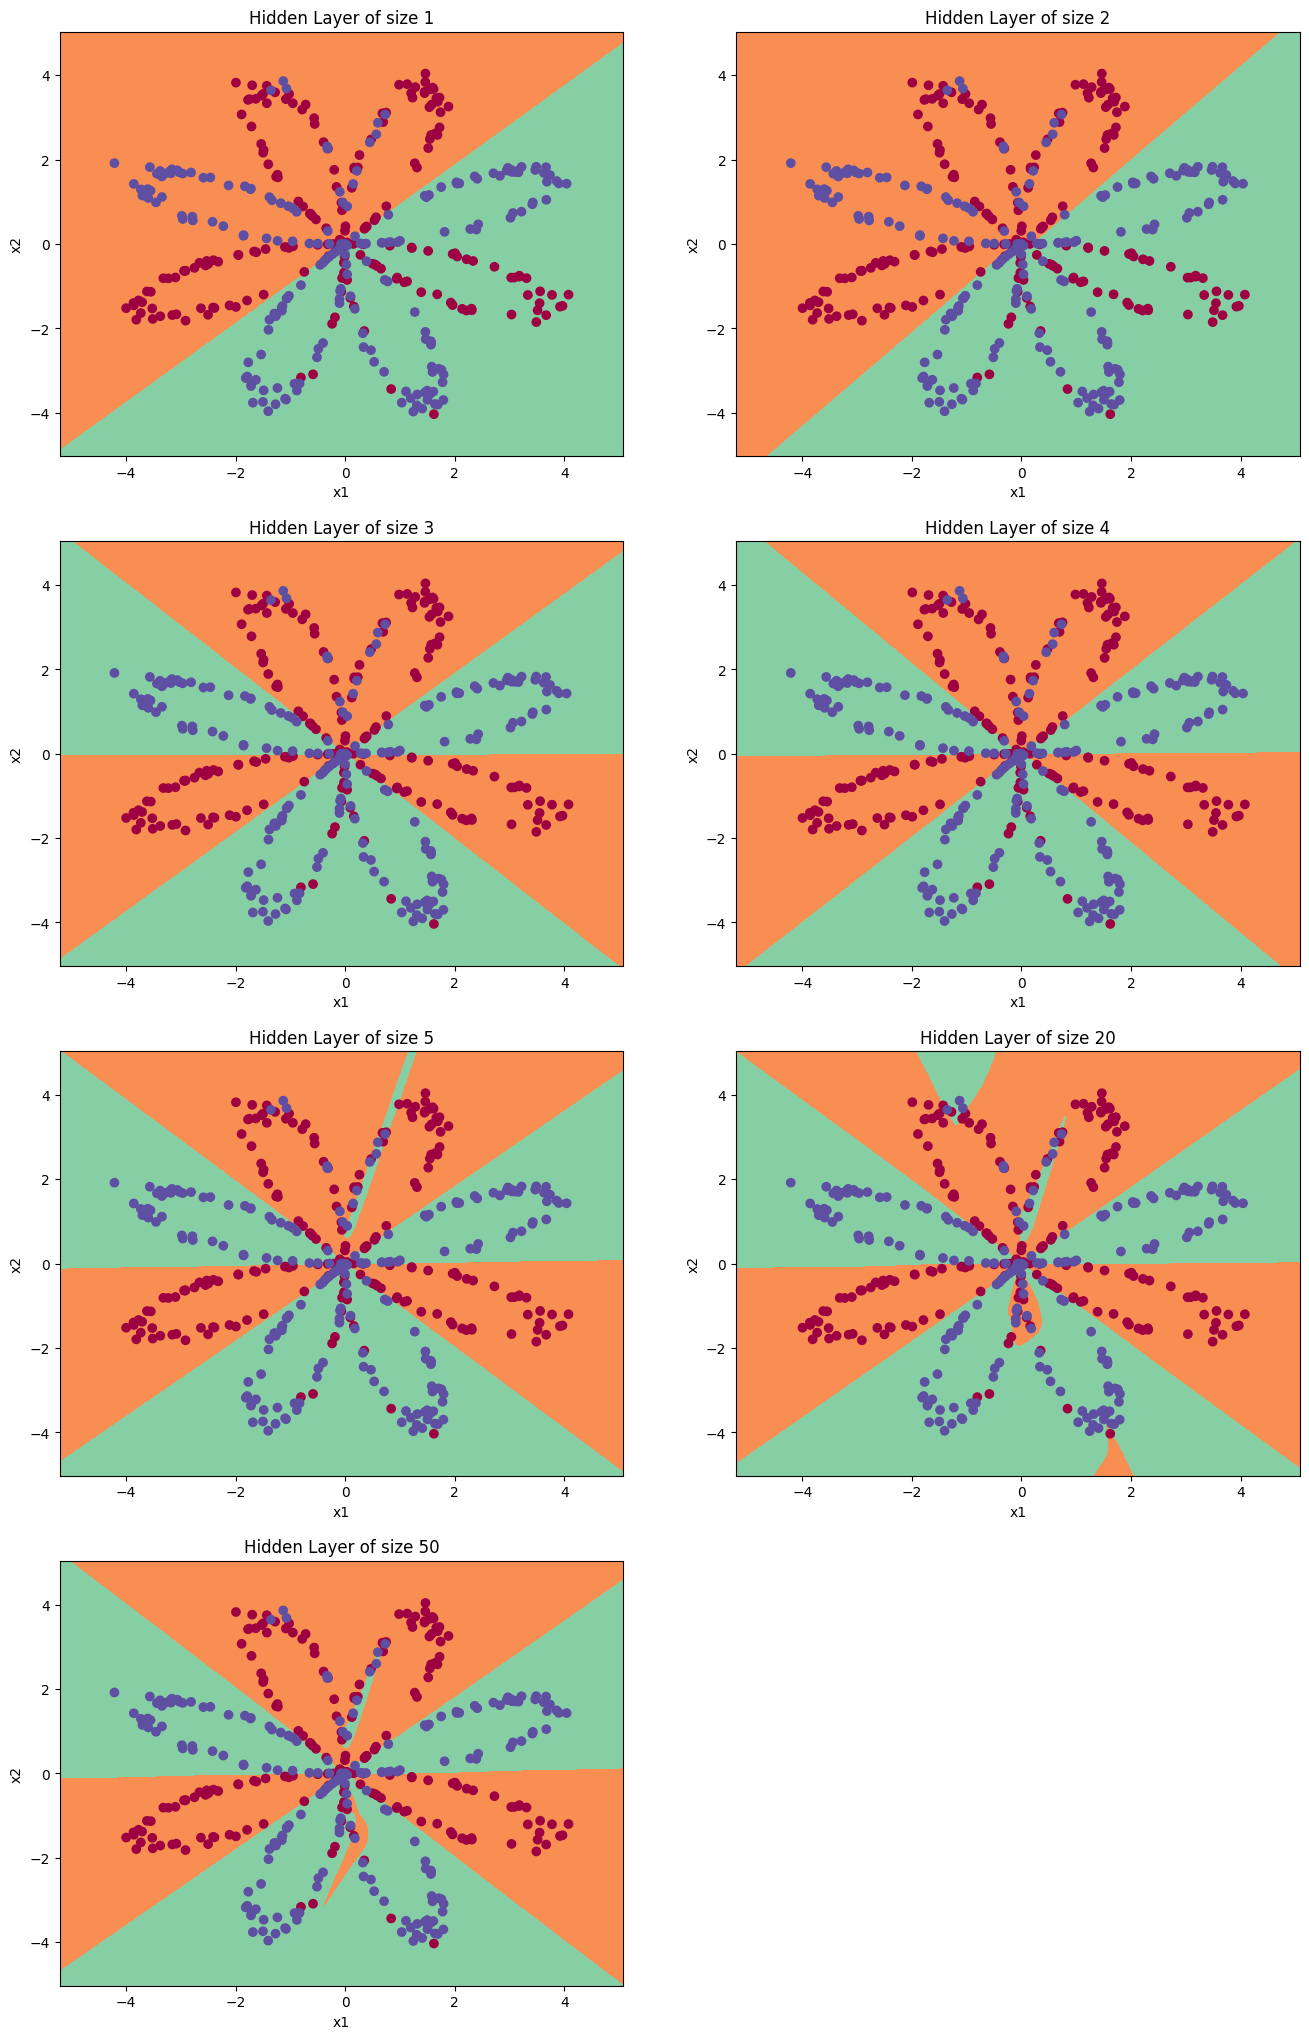

In [245]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, y, n_h1=n_h, n_h2=n_h, iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))